In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from ex_cosmology import p

# adaptive-wavelets modules
from awave.mdata.cosmology import get_dataloader, load_pretrained_model
from awave.mdata.cosmology import get_validation

# evaluation
from eval_cosmology import rmse_bootstrap
from peak_counting import PeakCount

ModuleNotFoundError: No module named 'awave.mdata'

In [ ]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path,
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size)

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)

# validation dataset
test_loader = get_validation(p.data_path,
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

# peak counting methods

In [3]:
# peak height
pco = PeakCount(peak_counting_method='original',
                bins=np.linspace(-0.03, 0.19, 23))
pco.fit(train_loader)
y_preds, y_params = pco.predict(test_loader)
acc, std = rmse_bootstrap(y_preds, y_params)
print("Peak counting: ", acc, std)

Peak counting:  0.016091585275421236 0.0004996632453856998


In [4]:
# laplace filter
pcl = PeakCount(peak_counting_method='laplace_v1',
                bins=np.linspace(0, 0.22, 23))
pcl.fit(train_loader)
y_preds, y_params = pcl.predict(test_loader)
acc, std = rmse_bootstrap(y_preds, y_params)
print("Laplace: ", acc, std)

Laplace:  0.013688726355797301 0.00046987392333715163


In [5]:
# roberts cross filter
pcr = PeakCount(peak_counting_method='roberts_cross',
                bins=np.linspace(0, 0.22, 23))
pcr.fit(train_loader)
y_preds, y_params = pcr.predict(test_loader)
acc, std = rmse_bootstrap(y_preds, y_params)
print("Roberts cross: ", acc, std)

Roberts cross:  0.012590893372170781 0.0003929773163417918


# model prediction

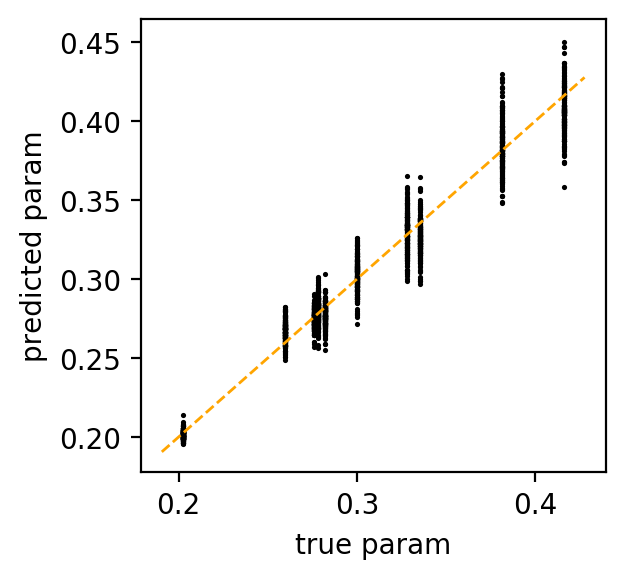

In [6]:
# check prediction
with torch.no_grad():
    result = {'y': [], 'pred': []}
    for data, params in test_loader:
        result['y'].append(params[:, 1].detach().cpu())
        result['pred'].append(model(data.to(device))[:, 1].detach().cpu())

fig = plt.figure(dpi=200, figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(torch.cat(result['y']),
           torch.cat(result['pred']),
           marker=".",
           alpha=1,
           zorder=0,
           color="black",
           s=3)
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, zorder=2, color="orange", linestyle='--', linewidth=1)
ax.set_xlabel("true param")
ax.set_ylabel("predicted param")
plt.show()

In [7]:
# model prediction
y_preds = torch.cat(result['y']).numpy()
y_params = torch.cat(result['pred']).numpy()
acc, std = rmse_bootstrap(y_preds, y_params, target=None)
print("Resnet: ", acc, std)

Resnet:  0.011563185462395783 0.00024013658473124436
